In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
df_owd = pd.read_csv("./dataset/1990-2020_day.csv", parse_dates=True)
df_owd['dt_iso'] = pd.to_datetime(df_owd['dt_iso'])
df_owd.head()

,dt_iso,temp_mean,temp_min_min,temp_max_max,pressure_mean,humidity_mean,wind_speed_mean,wind_deg_mean,clouds_all_mean,rain_1d
0,1990-01-01,26.333750,25.03,27.40,1009.333333,85.416667,1.477083,194.291667,91.541667,9.40
1,1990-01-02,25.559583,24.92,26.55,1009.666667,87.541667,2.096667,247.458333,99.958333,36.71
2,1990-01-03,26.956667,26.09,27.52,1008.583333,82.250000,2.122083,271.125000,96.000000,5.02
3,1990-01-04,26.638750,25.91,27.15,1007.958333,84.541667,2.652500,202.458333,98.541667,10.54
4,1990-01-05,27.940417,27.40,28.83,1007.916667,78.708333,2.905000,131.458333,99.708333,0.71


## EDA

Pola curah hujan dalam satu tahun

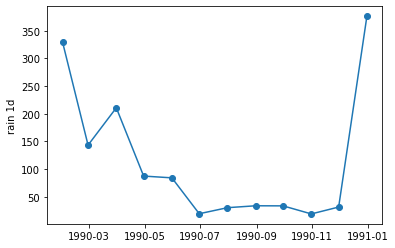

In [3]:
df_1990 = df_owd[(df_owd['dt_iso'] >= '1990-01-01') & (df_owd['dt_iso'] <= '1990-12-31')]
plt.plot(df_1990.groupby([pd.Grouper(key='dt_iso', freq='M')]).rain_1d.sum(), marker='o')
plt.ylabel("rain 1d")
plt.show()

Dari plot terlihat data mengikuti pola yang valid

- Denpasar mengikuti pola Monsoon, 
- Puncak musim hujan berada di **Dec-Jan-Feb (DJF)**
- Puncak musim kemarau berada di **Jun-Jul-Aug (JJA)**

<img src='images/pola.jpeg'></img>

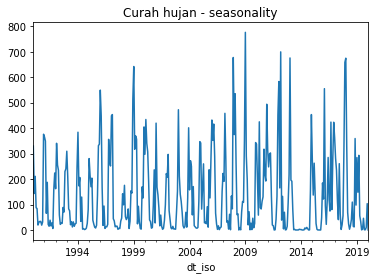

In [4]:
df_owd.groupby([pd.Grouper(key='dt_iso', freq='M')]).rain_1d.sum().plot()
plt.title('Curah hujan - seasonality')
plt.show()

In [ ]:
plt.figure(figsize=(14,8))
sns.set_theme(style="white")
corr = df_owd.corr()
heatmap = sns.heatmap(corr, annot=True, cmap="Blues", fmt='.1g')

Hasil korelasi parameter tidak ada korelasi yang kuat antara curah hujan dan parameter lainnya

Namun pada riset ini diangkut semua paramater karena parameter tersebut yang biasa dipakai dalam prediksi curah hujan

### Dataset Statistik

In [13]:
df_owd.describe()

,temp_mean,temp_min_min,temp_max_max,pressure_mean,humidity_mean,wind_speed_mean,wind_deg_mean,clouds_all_mean,rain_1d
count,10964.000000,10964.000000,10964.000000,10964.000000,10964.000000,10964.000000,10964.000000,10964.000000,10964.000000
mean,27.273347,24.848543,30.145240,1010.043557,80.814358,3.615097,157.916497,38.428085,4.545826
std,1.069445,1.391260,1.551929,1.995368,4.300660,1.394986,63.101959,14.729778,12.830629
min,22.401250,2.000000,23.200000,1001.129167,61.958333,0.998333,48.000000,6.083333,0.000000
25%,26.510208,24.000000,29.000000,1008.719792,78.125000,2.560729,111.291667,28.333333,0.000000
50%,27.337500,25.000000,30.000000,1010.125000,80.875000,3.402708,124.833333,35.000000,0.180000
75%,28.070729,25.800000,31.000000,1011.483333,83.666667,4.399271,207.666667,44.541667,2.310000
max,31.339167,28.800000,39.800000,1017.037500,98.000000,12.765833,321.250000,100.000000,221.000000


Terlihat terjadi data error pada temperatur minimum, tidak mungkin di daerah Denpasar mengalami suhu 2 derajat

Oleh karena itu, dilakukan cleansing dengan mengganti nilai temp_min_min < 22.4 dengan nilai 22.4 yaitu diambil dari temperture_mean minimum

### Cleansing

In [14]:
df_owd.loc[(df_owd['temp_min_min'] < 22.4), 'temp_min_min'] = 22.4

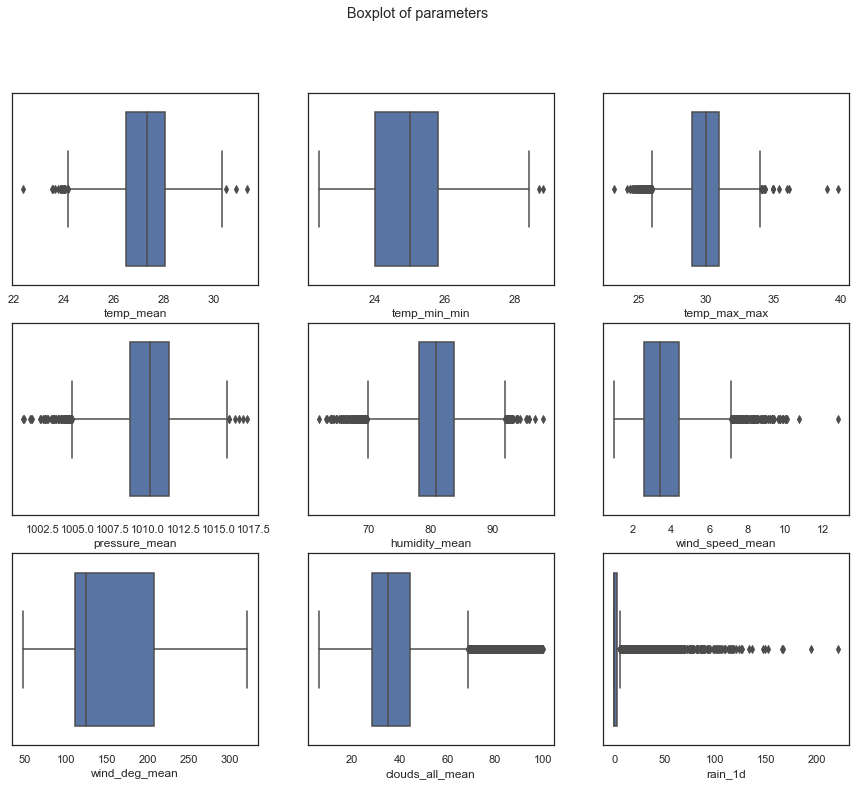

In [15]:
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
fig.suptitle('Boxplot of parameters')
i, j = 0, 0
for c in df_owd:
    if c != 'dt_iso':
        sns.boxplot(ax=axes[i, j], x=df_owd[c])

        j = j + 1
        if j >= 3:
            j = 0
            i = i + 1

Dari boxplot dapat dilihat bahwa yang mendekati distribusi normal hanyalah **temp_mean, pressure_mean, humidity_mean dan wind_deg_mean**

Sehingga untuk keseragaman maka normalisasi tidak menggunakan z-score melainkan min-max,  

## Preprocess

In [36]:
df_owd = df_owd.set_index('dt_iso')
norm_df_owd = (df_owd - df_owd.min(axis=0)) / (df_owd.max(axis=0) - df_owd.min(axis=0))
norm_df_owd.head()

,temp_mean,temp_min_min,temp_max_max,pressure_mean,humidity_mean,wind_speed_mean,wind_deg_mean,clouds_all_mean,rain_1d
dt_iso,,,,,,,,,
1990-01-01,0.439979,0.410938,0.253012,0.515715,0.650867,0.040684,0.535377,0.909938,0.042534
1990-01-02,0.353363,0.393750,0.201807,0.536668,0.709827,0.093336,0.729948,0.999556,0.166109
1990-01-03,0.509673,0.576562,0.260241,0.468570,0.563006,0.095496,0.816560,0.957409,0.022715
1990-01-04,0.474104,0.548438,0.237952,0.429282,0.626590,0.140571,0.565264,0.984472,0.047692
1990-01-05,0.619738,0.781250,0.339157,0.426663,0.464740,0.162028,0.305428,0.996894,0.003213


In [ ]:
#Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 14  # Number of past days we want to use to predict the future.

#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_training_scaled has a shape (12823, 5)
#12823 refers to the number of data points and 5 refers to the columns (multi-variables).
for i in range(n_past, len(norm_df_owd) - n_future +1):
    trainX.append(norm_df_owd[i - n_past:i, 0:norm_df_owd.shape[1]])
    trainY.append(norm_df_owd[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))